In [1]:
# For user-defined post processing and plotting functions
import sys
sys.path.insert(0, "../../..")
from utils.plot_utils_v2 import *

Welcome to the "how to" of Markov Chain Monte Carlo using PYMC. A python software package allowing you to fit complex models with ease. 

## Case Study 3: Monod Growth Model with Explicit Resources

We are going to establish a Monod Growth model in this case study. The ODE and it's solution will be defined in the near future.  

First things first. Data! Pandas is the defacto python package for reading in data. It's also smart to handle any necessary data conversions during this step. Our data spans many magnitudes, so we will go ahead and perform our log conversion now. You may not need to and that's just fine! You may not need to and that's just fine! It all depends on what you are looking for.

Note: The "+ 1e-9" is merely a fail-safe against divide-by-zero errors when doing a log transform. Adding a value infitesimally near 0 makes no impact on the data itself and prevents the aformentioned error. Good quick trick to know!

In [2]:
## Cell 1 ##

import pandas as pd
import numpy as np

dataset = pd.read_csv("../../../case_study_3/python/data/total_cells.csv")
ehux_cells = dataset.tail(15)
ehux_total_time = ehux_cells['Time (days)'].values
ehux_total_density = 1e6*ehux_cells[' Density (1e6/ml)'].values
log_ehux_total_density = np.log(ehux_total_density + 1e-9)

death_dataset = pd.read_csv("../../../case_study_3/python/data/death_percentage.csv")
ehux_death = death_dataset.tail(15)
ehux_death_time = ehux_death['Time (days)'].values
ehux_dead_density = ehux_death[' Dead percentage '].values*ehux_total_density/100
log_ehux_dead_density = np.log(ehux_dead_density + 1e-9)

Here is the first thing that needs to be done. We will setup the ODE system that will adapt to the data. To do this, you will use variables that PyMC gives you by 'default' (y, t, params). 

**mu_max**: Maximum Specific Growth Rate  
**Ks**: Half-Saturation Constant  
**Qn**: Nutrient Consumption per Cell  
**delta**: Death Rate  
**P_m3**: Unit Conversion  

$$
\begin{aligned}  
\mu(N) &= \mu_{\text{max}} \frac{N}{K_s + N} \\
\frac{dN}{dt} &= - Q_n \, \mu(N) \, P_{\text{m}^3} \\
\frac{dP}{dt} &= \mu(N) \, P - \delta \, P \\
\frac{dD}{dt} &= \delta \, P \\
\end{aligned}  
$$




In [3]:
## Cell 2 ##

def general_case(t, y, params):
    N, P, D = y
    mu_max = params[0]
    Ks = params[1]
    Qn = params[2]
    delta = params[3]
    P_m3 = P * 1e6  # cells/mL → cells/m³

    mu = mu_max * N / (N + Ks)
    dNdt = -Qn * mu * P_m3
    dPdt = mu * P - delta * P
    dDdt = delta * P
   
    return [dNdt, dPdt, dDdt]


Here is where this case becomes unique. This ODE system is stiff. This happens when rates of change within a system vary drastically. This will cause the process to lock up if you don't use a proper sampler / solver. Here is how we chose to solve the issue. 

We are still going to use PyMC, however, instead of using the integrated solver we will use an external SciPy ODE solver to get around the stiffness issue. We declare a custom operator (**Op**) with one input vector (**itypes**) and one output matrix (**otypes**). It will be initialized with your observed times. **perform** is the default call for the runtime computation of the **Op**. See in Cell 5 how the parameters and inital values are passed to the **Op**. The first 4 are the parameters and last 3 are the initial conditions (**theta** and **y0**).

The solve_ivp call should follow this form. The inputs to the function are as follows:

**fun**: The ODE function(s)  
**t_span**: first and last time  
**y0**: Initial Values  
**t_eval**: exact time points the ODE will be evaluated at  
**method**: This is up to the user but for our case we chose LSODA. It auto-detects stiffness and switches between Adams (non-stiff) and BDF (stiff) methods.

Lastly, the output is transposed to match the form PyMC expects. 

In [4]:
## Cell 3 ##

import pytensor.tensor as pt
from pytensor.graph.op import Op
from scipy.integrate import solve_ivp

class SolveIVPWrapper(Op):
    itypes = [pt.dvector]  # theta + y0
    otypes = [pt.dmatrix]  # solution: (len(t), 3)

    def __init__(self, times):
        self.times = times

    def perform(self, node, inputs, outputs):
        theta_y0, = inputs
        theta = theta_y0[:4] # first 4
        y0 = theta_y0[4:] # last 3

        sol = solve_ivp(
            fun=lambda t, y: general_case(t, y, theta),
            t_span=(self.times[0], self.times[-1]),
            y0=y0,
            t_eval=self.times,
            method="LSODA"
        )

        if not sol.success:
            raise RuntimeError("ODE solver failed:", sol.message)

        outputs[0][0] = sol.y.T  # shape: (time, 3)

This is where we create the MCMC 'loop': Sample Priors -> Estimate ODE @ times -> check fit

First, proirs. You have all kinds of options. Uniform, normal, lognormal, halfnormal. It all depends on what you need. For our parameters we choose uniform priors. These uniform priors say, "we believe the proper value for the model will be equally likely within this range and WILL NOT be outside of it". For our initial conditions we choose a lognormal distribution. This says, "we believe our value is around some **x** given a normalesque strictly positive distribution". For our sigma terms (error), we choose a halfnormal distribution. This is usually used for your error or standard deviation since neither can be negative and you can tune how quickly it tails off. Below are the priors visualized. 

<img src="../../figures/priors_c3.png" width="450"/>

After the priors are declared the next function call will be for the solution of the model given its current estimates. Pay attention to the order in which you pass your priors!

The final functions are the likelihood estimations of the model's states. This is where the model tests how well it estimated the observed data. We pass it our log transformed estimated data, the sigma values from the iteration's sample, and log transformed observed data. Now just let PyMC simply work its magic!

In [ ]:
## Cell 5 ##

import pymc as pm

ode_op = SolveIVPWrapper(ehux_total_time)

with pm.Model() as model:
    mu_max = pm.Uniform("mu_max", 0.4, 0.7)
    Ks = pm.Uniform("Ks", 0.05, 0.2)
    Qn = pm.Uniform("Qn", 1e-10, 7e-10)
    delta = pm.Uniform("delta", 0.01, 0.09)

    # N0 isn't a 'prior' distribution. It is deterministic. Meaing, N0 will be a 
    # variable tracked by the model, but at each iteration it exists as a function
    # of Qn. 
    N0 = pm.Deterministic("N0", 1000 + ((500 / 1.8e-10) * (Qn - 3.2e-10)))
    
    P0 = pm.LogNormal("P0", mu=12.2175, sigma=0.1)
    D0 = pm.LogNormal("D0", mu=10.2804, sigma=0.1)

    sigma_live = pm.HalfNormal("sigma_live", 1)
    sigma_dead = pm.HalfNormal("sigma_dead", 1)

    # Solve ODE
    sol = ode_op(pt.stack([mu_max, Ks, Qn, delta, N0, P0, D0]))

    total = sol[:, 1] + sol[:, 2]
    dead = sol[:, 2]

    pm.Normal("Y_total", mu=pm.math.log(total + 1e-9), sigma=sigma_live, observed=log_ehux_total_density)
    pm.Normal("Y_dead", mu=pm.math.log(dead + 1e-9), sigma=sigma_dead, observed=log_ehux_dead_density)

This is how you call and run the model!

**draws**: poterior values to be generated.  
**tune**: Some under the hood PyMC magic that 'warms it up'. Keep this between 500 and 2000 depending on how complex your model is.  
**chains / cores**: Amount of chains you want to compute in parallel. Keep these values the same for most basic usage. PyMC recommends you run at least 4 chains.    
**step**: By default PyMC uses NUTS (No U-Turn Sampler). If you want to use something other than NUTS this is where you declare it.  
**return_inferencedata**: returns an ARVIZ inferencedata object which we'll use for easy reading of our output.  

In [10]:
## Cell 6 ##

with model:
    trace = pm.sample(draws=10000, 
                      tune=1000, 
                      chains=4, 
                      cores=4,
                      step=pm.Metropolis(),
                      return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu_max]
>Metropolis: [Ks]
>Metropolis: [Qn]
>Metropolis: [delta]
>Metropolis: [P0]
>Metropolis: [D0]
>Metropolis: [sigma_live]
>Metropolis: [sigma_dead]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 416 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


To interpret the output we have some user-defined postprocessing and plotting functions. They are in our GitHub repo.

Sampling: [D0, Ks, P0, Qn, Y_dead, Y_total, delta, mu_max, sigma_dead, sigma_live]


mu_max
Ks
Qn
delta
P0
D0
sigma_live
sigma_dead


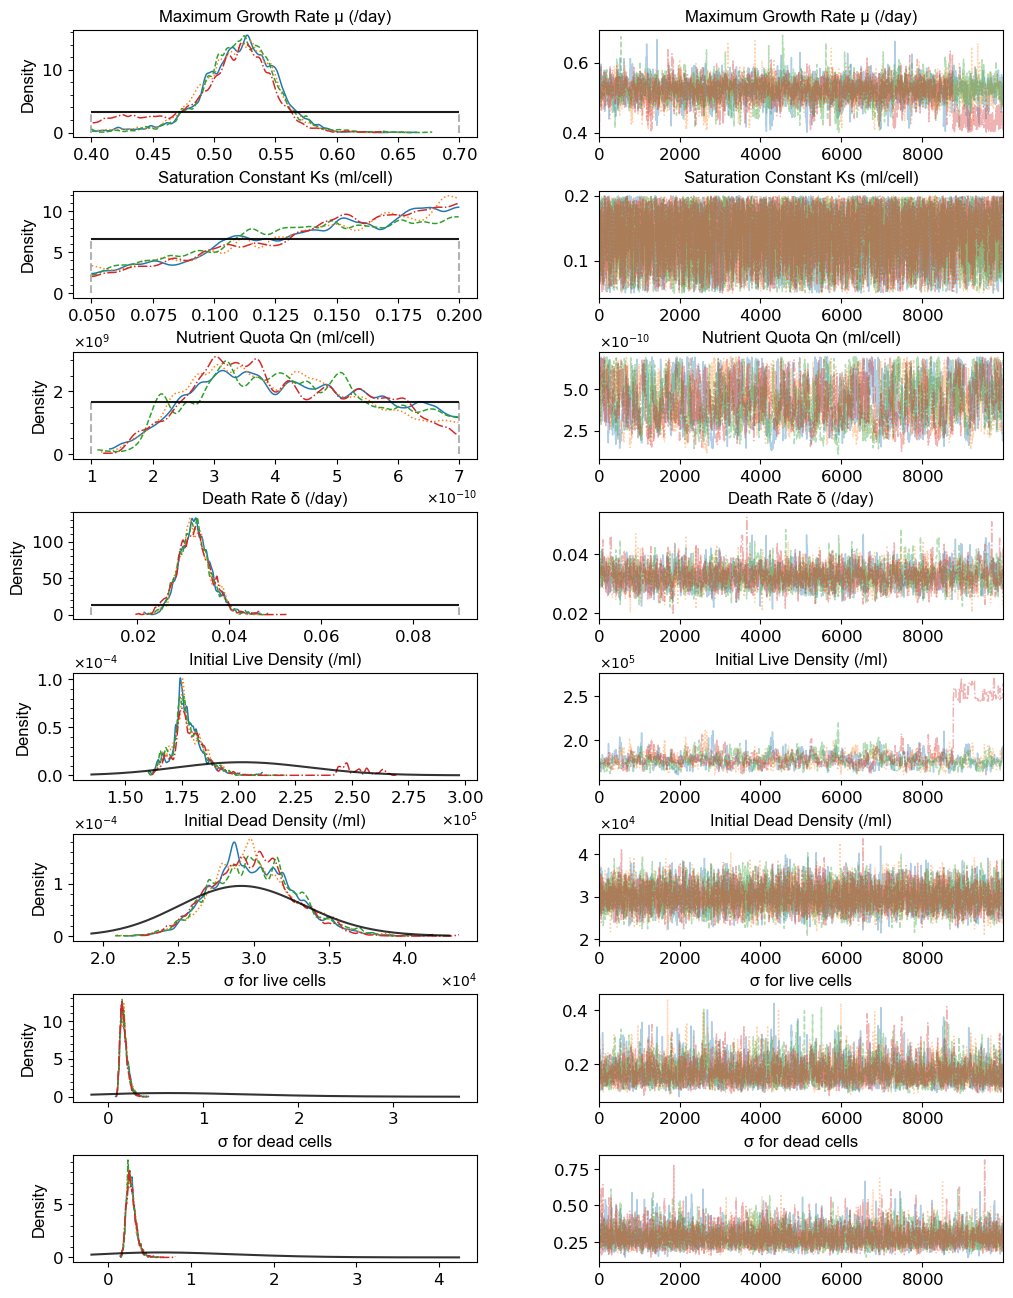

array([[<Axes: title={'center': 'Maximum Growth Rate μ (/day)'}, ylabel='Density'>,
        <Axes: title={'center': 'Maximum Growth Rate μ (/day)'}>],
       [<Axes: title={'center': 'Saturation Constant Ks (ml/cell)'}, ylabel='Density'>,
        <Axes: title={'center': 'Saturation Constant Ks (ml/cell)'}>],
       [<Axes: title={'center': 'Nutrient Quota Qn (ml/cell)'}, ylabel='Density'>,
        <Axes: title={'center': 'Nutrient Quota Qn (ml/cell)'}>],
       [<Axes: title={'center': 'Death Rate δ (/day)'}, ylabel='Density'>,
        <Axes: title={'center': 'Death Rate δ (/day)'}>],
       [<Axes: title={'center': 'Initial Live Density (/ml)'}, ylabel='Density'>,
        <Axes: title={'center': 'Initial Live Density (/ml)'}>],
       [<Axes: title={'center': 'Initial Dead Density (/ml)'}, ylabel='Density'>,
        <Axes: title={'center': 'Initial Dead Density (/ml)'}>],
       [<Axes: title={'center': 'σ for live cells'}, ylabel='Density'>,
        <Axes: title={'center': 'σ for liv

In [13]:
plot_trace(trace=trace,
           model=model,
           uni=["mu_max", "Ks", "Qn", "delta"],
           fontname='Arial',
           fontsize=12,
           num_prior_samples=2000,
           var_names_map={'mu_max': 'Maximum Growth Rate μ (/day)', 'Ks': 'Saturation Constant Ks (ml/cell)', 'delta': 'Death Rate δ (/day)', 'Qn': 'Nutrient Quota Qn (ml/cell)', 'P0': 'Initial Live Density (/ml)', 'D0': 'Initial Dead Density (/ml)','sigma_live': 'σ for live cells', 'sigma_dead': 'σ for dead cells'},
           var_order=['mu_max', 'Ks', 'Qn', 'delta','P0','D0','sigma_live','sigma_dead'],
           save_path='figures/vardi_general_chains_reparam.png')

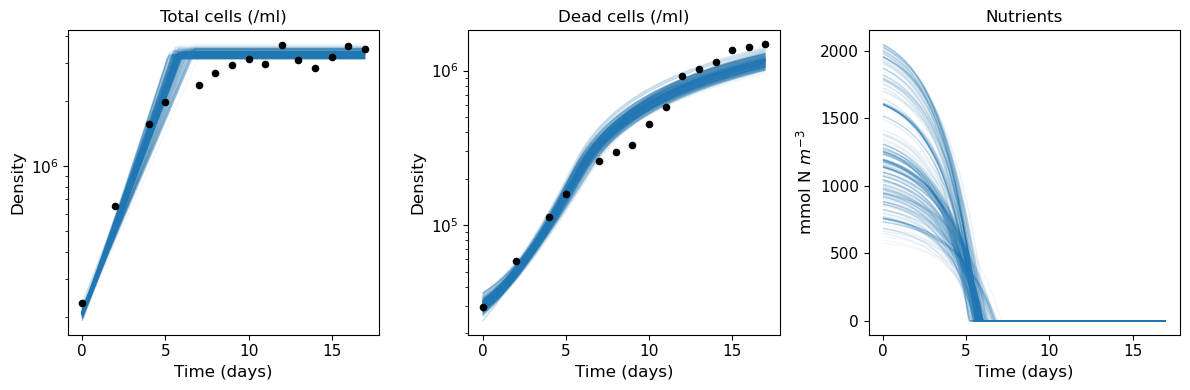

In [12]:
def ode_solution2data(solution):
    live = solution[:, 1]
    dead = solution[:, 2]
    total = live + dead
    return {
        "total": total,
        "dead": dead
    }

case_3_posteriors(trace, 
                  ehux_total_time, 
                  ehux_death_time, 
                  ehux_total_density, 
                  ehux_dead_density, 
                  general_case, 
                  ode_solution2data)

Now we interpret the results. Remember the ODE system from before. 

$$
\begin{aligned}  
\mu(N) &= \mu_{\text{max}} \frac{N}{K_s + N} \\
\frac{dN}{dt} &= - Q_n \, \mu(N) \, P_{\text{m}^3} \\
\frac{dP}{dt} &= \mu(N) \, P - \delta \, P \\
\frac{dD}{dt} &= \delta \, P \\
\end{aligned}  
$$

Here we will look at the above plots in tandem. Take note of the x-axis values at the peaks of the PDF's and the variables they represent. Those are the optimal values for their variables for the system. The right hand column is a frequency plot. This is just to make sure the model is exploring the parameter space. Now, see that not all the varibles are 'fit'. **Ks** doesn't have a peak, its flat. If you see this alone it may seem problematic. This is why looking at posterior draws over the data is important. We can see that our model fits the data very well, therefore the flat **Ks** estimate means the model is not dependent on that value. Which is fine! This is the importance of clear post processing. 

## Additional NUTS Output

Using NUTS is still possible and can result in appealing estimates. However, take note of the warning displayed by PyMC. True this is just a warning, but warnings are NEVER to be ignored. If there is a proper justification and knowledge behind your decision, you are obviously free to make it. The rest of the time, always take care of warnings. 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Slice: [mu_max]
>>Slice: [Ks]
>>Slice: [Qn]
>>Slice: [delta]
>>Slice: [P0]
>>Slice: [D0]
>NUTS: [sigma_live, sigma_dead]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 165 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [D0, Ks, P0, Qn, Y_dead, Y_total, delta, mu_max, sigma_dead, sigma_live]


mu_max
Ks
Qn
delta
P0
D0
sigma_live
sigma_dead


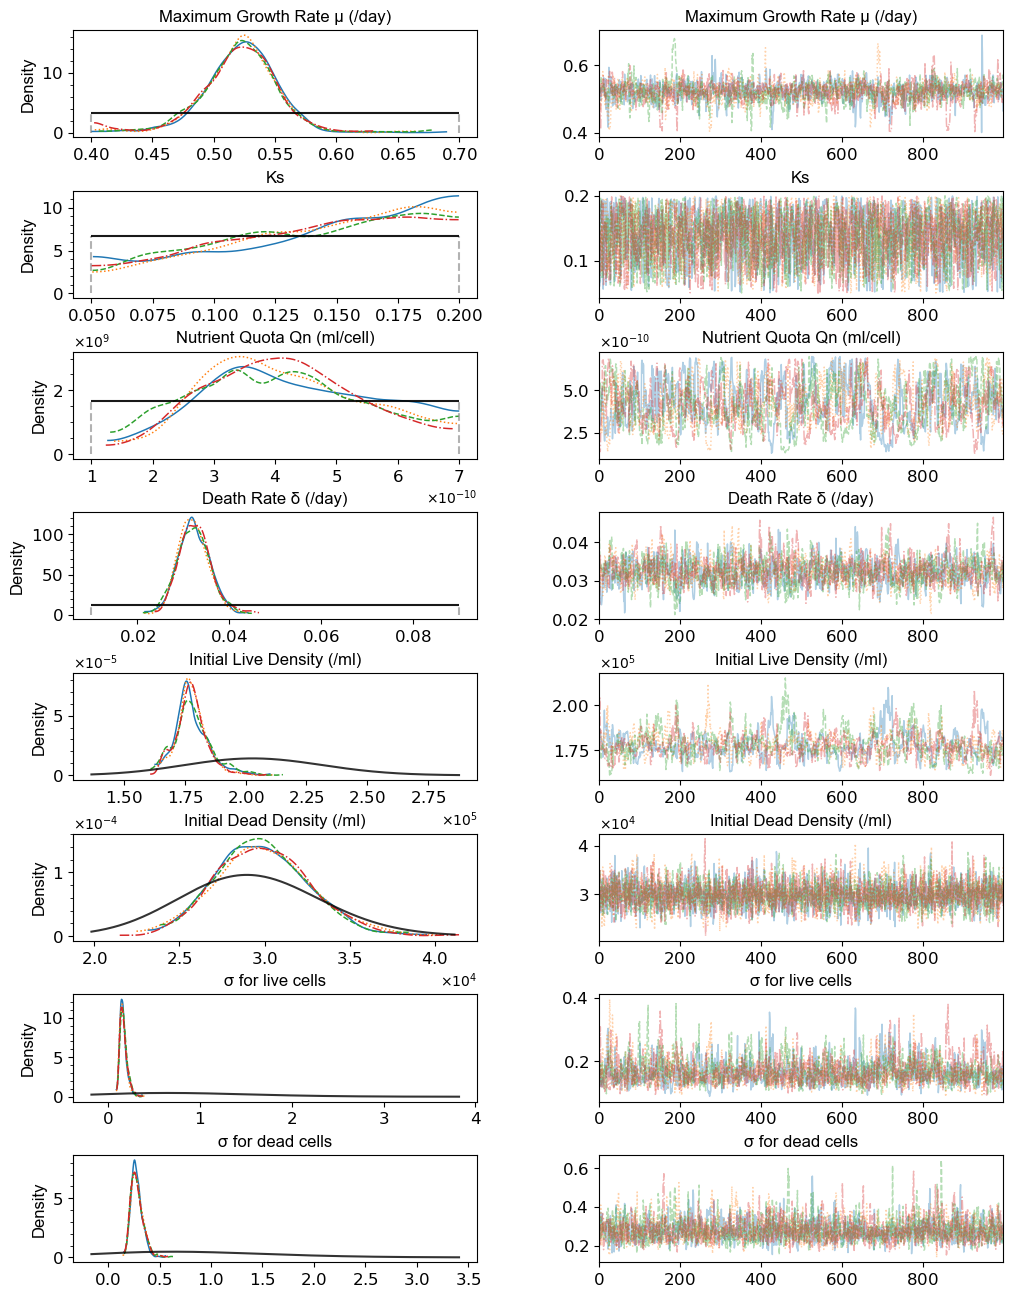

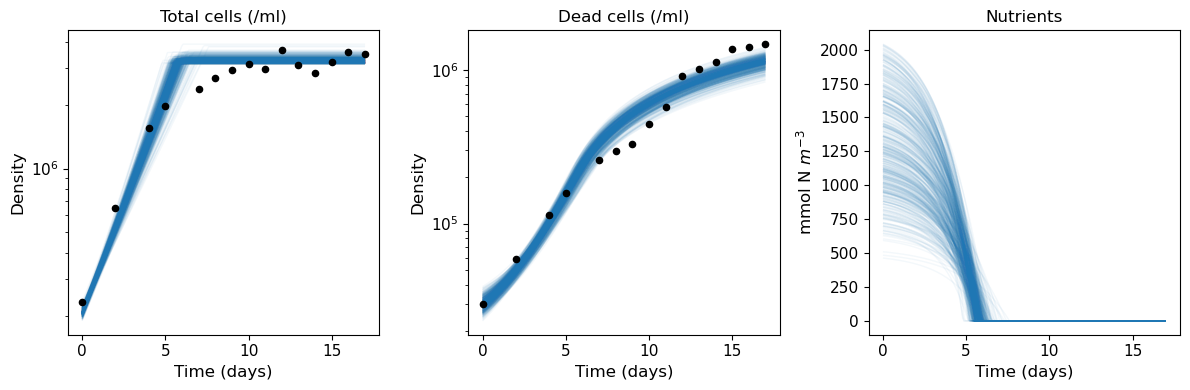

In [9]:
with model:
    trace = pm.sample(draws=1000, 
                      tune=1000, 
                      chains=4, 
                      target_accept=0.95,
                      return_inferencedata=True, 
                      cores=4)
    
plot_trace(trace=trace,
           model=model,
           uni=["mu_max", "Ks", "Qn", "delta"],
           fontname='Arial',
           fontsize=12,
           num_prior_samples=2000,
           var_names_map={'mu_max': 'Maximum Growth Rate μ (/day)', 'delta': 'Death Rate δ (/day)', 'Qn': 'Nutrient Quota Qn (ml/cell)', 'P0': 'Initial Live Density (/ml)', 'D0': 'Initial Dead Density (/ml)','sigma_live': 'σ for live cells', 'sigma_dead': 'σ for dead cells'},
           var_order=['mu_max', 'Ks', 'Qn', 'delta','P0','D0','sigma_live','sigma_dead'],
           save_path='figures/vardi_general_chains_reparam.png')

def ode_solution2data(solution):
    live = solution[:, 1]
    dead = solution[:, 2]
    total = live + dead
    return {
        "total": total,
        "dead": dead
    }

case_3_posteriors(trace, 
                  ehux_total_time, 
                  ehux_death_time, 
                  ehux_total_density, 
                  ehux_dead_density, 
                  general_case, 
                  ode_solution2data)